<a href="https://colab.research.google.com/github/Champioa00/LAB1/blob/master/YESSIR5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## LAB 2 ##
## Anthony Champion ##
## IST 718 ##

In [ ]:
## Load required packages ##
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
#from botocore.client import Config
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm
from  multiprocessing import Pool, cpu_count
import pandas as pd
import numpy as np
#import ibm_boto3
import itertools
import types
import math
import time

sns.set(rc={'figure.figsize':(11.7,8.27)})
%matplotlib inline 

In [15]:
from tqdm import tqdm

DATA Cleaning:

Let's start with importing the difffernt data sets.  From there we can explore and perform the needed data cleansing. 



In [9]:
df_data_1 = pd.read_csv('Zip_zhvi_uc_sfr_month.csv')
df_data_1.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.792330e+06,2.687480e+06,2.750319e+06,2.745687e+06,2.672237e+06,2.703466e+06,2.799758e+06,2.762261e+06,2.972422e+06,2.964929e+06,2.941399e+06,2.770281e+06,2.709474e+06,2.807152e+06,2.757996e+06,2.898636e+06,2.883489e+06,2.813502e+06,2.835291e+06,2.864990e+06,2.710262e+06,2.851837e+06,2.915106e+06,2.778842e+06,2.812505e+06,2.801768e+06,2.872429e+06,2869819.021,2.792227e+06,2.880981e+06,2.936416e+06,3.033201e+06,2.904437e+06,2.801494e+06,2.721834e+06,2.640603e+06,2.616576e+06,2.600348e+06,2.563603e+06,2.729760e+06
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,327184.4715,327713.4837,325984.4579,332778.2610,334414.5751,337601.7483,337856.7732,340445.1863,346222.3082,348798.2996,353450.8352,352990.2028,354387.5651,357231.4176,359681.4492,361963.9914,372552.6507,369575.8297,373462.4970,348818.2141,341442.7292,323433.5647,315459.2506,316542.5223,295871.2783,300335.2839,300666.0235,309593.5198,315575.7585,329702.7681,340326.4415,...,7.892213e+05,7.910212e+05,7.899114e+05,7.805394e+05,7.872967e+05,7.919914e+05,7.900941e+05,7.925490e+05,7.910878e+05,7.864774e+05,7.838324e+05,7.801943e+05,7.750737e+05,7.740944e+05,7.725794e+05,7.801559e+05,7.915183e+05,7.910302e+05,7.915584e+05,7.939067e+05,7.876053e+05,7.908220e+05,7.917972e+05,7.999406e+05,8.017769e+05,7.938478e+05,7.989722e+05,797140.864,8.138223e+05,8.136838e+05,8.204414e+05,8.171122e+05,8.237994e+05,8.301982e+05,8.286601e+05,8.252674e+05,8.381829e+05,8.389180e+05,8.381373e+05,8.495258e+05
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.306724e+06,5.303907e+06,5.307117e+06,5.156562e+06,5.249348e+06,5.182788e+06,5.058869e+06,5.166357e+06,5.043388e+06,5.041397e+06,4.900863e+06,4.846561e+06,4.806427e+06,4.780078e+06,4.760010e+06,4.874589e+06,4.783694e+06,4.670615e+06,4.821009e+06,4.831602e+06,4.917240e+06,4.823658e+06,4.681429e+06,4.742684e+06,4.750099e+06,4.737670e+06,4.734036e+06,4503091.435,4.820726e+06,5.032885e+06,5.072752e+06,5.104681e+06,4.991198e+06,5.204816e+06,5.430261e+06,5.489555e+06,5.183702e+06,5.143927e+06,5.115112e+06,5.111999e+06
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178597.7329,182239.3716,181934.9870,179668.4547,184266.4870,183117.2403,188706.1648,183779.9983,186036.3819,182704.3914,184768.1298,187562.7857,189633.2751,189402.0634,193389.9616,199159.9068,199053.6127,201124.2151,205113.1101,209095.7221,211203.2530,207095.6308,207235.3069,204503.8534,203883.6108,205334.1647,203134.1089,203749.4133,203032.1247,203485.1372,202113.1230,...,3.530590e+05,3.541628e+05,3.525020e+05,3.554251e+05,3.556854e+05,3.553540e+05,3.555060e+05,3.568726e+05,3.563078e+05,3.568684e+05,3.551285e+05,3.563217e+05,3.550922e+05,3.540023e+05,3.537106e+05,3.547125e+05,3.549502e+05,3.582089e+05,3.608014e+05,3.609959e+05,3.610848e+05,3.610934e+05,3.634250e+05,3.641847e+05,3.671116e+05,3.720254e+05,3.768957e+05,380199.342,3.884185e+05,3.970397e+05,4.039702e+05,4.138433e+05,4.270610e+05,4.386916e+05,4.466750e+05,4.535979e+05,4.605603e+05

In [10]:
## Check to see if the data was loaded correctly ##
na_values = df_data_1.isna().sum()
print(na_values)

RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      0
              ..
2021-09       60
2021-10       44
2021-11       26
2021-12        0
2022-01        0
Length: 322, dtype: int64


In [ ]:
list(na_values.index)

In [12]:
## Load in metro data from the US Department of Labor ##
metro_area = pd.read_csv('OD.csv')
metro_area.head()


,ZIP CODE,STATE,MSA No.,GPCI_W,GPCI_PE,GPCI_ME,County No.,MSA Name
0,210,NH,14460.0,1.0,1.046,0.658,15.0,"Boston-Cambridge-Quincy, MA-NH MSA"
1,211,NH,14460.0,1.0,1.046,0.658,15.0,"Boston-Cambridge-Quincy, MA-NH MSA"
2,212,NH,14460.0,1.0,1.046,0.658,15.0,"Boston-Cambridge-Quincy, MA-NH MSA"
3,213,NH,14460.0,1.0,1.046,0.658,15.0,"Boston-Cambridge-Quincy, MA-NH MSA"
4,214,NH,14460.0,1.0,1.046,0.658,15.0,"Boston-Cambridge-Quincy, MA-NH MSA"


In [13]:
# Keep data with missing metro name. 
missing_metro = df_data_1[df_data_1['Metro'].isna()]
missing_index = missing_metro.index

# Drop observation without Metro data. These observations will then be reattached
df_metro_complete = df_data_1.drop(index=missing_index)

# Keep zip code and msa name from the metro_area data set
metro_area_simp = metro_area[['ZIP CODE', 'MSA Name']]

# Merge missing metro with metro_area_simp 
metro_complete = missing_metro.merge(metro_area_simp, how='left', left_on='RegionName', right_on='ZIP CODE')

In [14]:
# Check to see that there are no NaN variables in the new column. 
print(metro_complete['MSA Name'].isna().sum())

# There are no NaN values now. We'll now replace the Metro column with the MSA Name column, drop the overlapping columns, and 
# reattach the observations to the df_data_1 data set. 
metro_complete['Metro'] = metro_complete['MSA Name']
metro_complete1 = metro_complete.iloc[:, 0:322]

# Reattach data to original data. 
df_data_1 = df_metro_complete.append(metro_complete1)
print(df_data_1.shape)

0
(31990, 322)


In [28]:
df_data_2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,228165.313018,233969.358296,233133.064945,233443.970861,237353.998041,237486.585262,238150.921270,239538.443050,239793.729378,240699.035363,241930.896414,242230.916226,243306.330079,243374.943609,244168.123100,244800.614066,246075.490814,247681.544210,250038.248818,251547.997078,251334.345944,252624.571633,256025.444268,257593.000051,259983.312856,259983.694731,260806.926778,262810.475357,264848.773670,266633.813405,268861.124317,...,2.792330e+06,2.687480e+06,2.750319e+06,2.745687e+06,2.672237e+06,2.703466e+06,2.799758e+06,2.762261e+06,2.972422e+06,2.964929e+06,2.941399e+06,2.770281e+06,2.709474e+06,2.807152e+06,2.757996e+06,2.898636e+06,2.883489e+06,2.813502e+06,2.835291e+06,2.864990e+06,2.710262e+06,2.851837e+06,2.915106e+06,2.778842e+06,2.812505e+06,2.801768e+06,2.872429e+06,2.869819e+06,2.792227e+06,2.880981e+06,2.936416e+06,3.033201e+06,2.904437e+06,2.801494e+06,2.721834e+06,2.640603e+06,2.616576e+06,2.600348e+06,2.563603e+06,2.729760e+06
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,327184.471500,327713.483700,325984.457900,332778.261000,334414.575100,337601.748300,337856.773200,340445.186300,346222.308200,348798.299600,353450.835200,352990.202800,354387.565100,357231.417600,359681.449200,361963.991400,372552.650700,369575.829700,373462.497000,348818.214100,341442.729200,323433.564700,315459.250600,316542.522300,295871.278300,300335.283900,300666.023500,309593.519800,315575.758500,329702.768100,340326.441500,...,7.892213e+05,7.910212e+05,7.899114e+05,7.805394e+05,7.872967e+05,7.919914e+05,7.900941e+05,7.925490e+05,7.910878e+05,7.864774e+05,7.838324e+05,7.801943e+05,7.750737e+05,7.740944e+05,7.725794e+05,7.801559e+05,7.915183e+05,7.910302e+05,7.915584e+05,7.939067e+05,7.876053e+05,7.908220e+05,7.917972e+05,7.999406e+05,8.017769e+05,7.938478e+05,7.989722e+05,7.971409e+05,8.138223e+05,8.136838e+05,8.204414e+05,8.171122e+05,8.237994e+05,8.301982e+05,8.286601e+05,8.252674e+05,8.381829e+05,8.389180e+05,8.381373e+05,8.495258e+05
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,228165.313018,233969.358296,233133.064945,233443.970861,237353.998041,237486.585262,238150.921270,239538.443050,239793.729378,240699.035363,241930.896414,242230.916226,243306.330079,243374.943609,244168.123100,244800.614066,246075.490814,247681.544210,250038.248818,251547.997078,251334.345944,252624.571633,256025.444268,257593.000051,259983.312856,259983.694731,260806.926778,262810.475357,264848.773670,266633.813405,268861.124317,...,5.306724e+06,5.303907e+06,5.307117e+06,5.156562e+06,5.249348e+06,5.182788e+06,5.058869e+06,5.166357e+06,5.043388e+06,5.041397e+06,4.900863e+06,4.846561e+06,4.806427e+06,4.780078e+06,4.760010e+06,4.874589e+06,4.783694e+06,4.670615e+06,4.821009e+06,4.831602e+06,4.917240e+06,4.823658e+06,4.681429e+06,4.742684e+06,4.750099e+06,4.737670e+06,4.734036e+06,4.503091e+06,4.820726e+06,5.032885e+06,5.072752e+06,5.104681e+06,4.991198e+06,5.204816e+06,5.430261e+06,5.489555e+06,5.183702e+06,5.143927e+06,5.115112e+06,5.111999e+06
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178597.732900,182239.371600,181934.987000,179668.454700,184266.487000,183117.240300,188706.164800,183779.998300,186036.381900,182704.391400,184768.129800,187562.785700,

In [ ]:
# Obtain column names of year-month combinations. 
year_month = df_data_1.iloc[:, 9:].columns.values

df_data_2 = df_data_1

# Iterate over year-month combination, replacing NaN with average value for metropolitan area 
for ym in tqdm(df_data_2[year_month]):
  print(ym)
  df_data_2[ym] = df_data_2.groupby('Metro')[ym].transform(lambda x: x.fillna(x.mean()))

In [ ]:
df_data_2.describe()

,RegionID,SizeRank,RegionName,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01
count,31990.000000,31990.000000,31990.000000,2.687100e+04,2.700800e+04,2.700800e+04,2.703100e+04,2.713300e+04,2.713900e+04,2.713900e+04,2.715800e+04,2.715800e+04,2.717100e+04,2.719800e+04,2.719800e+04,2.738300e+04,2.738600e+04,2.740100e+04,2.744700e+04,2.744700e+04,2.744700e+04,2.748100e+04,2.752300e+04,2.752300e+04,2.752300e+04,2.755200e+04,2.757600e+04,2.759300e+04,2.759300e+04,2.760200e+04,2.785900e+04,2.797800e+04,2.797800e+04,2.797800e+04,2.800500e+04,2.800800e+04,2.800800e+04,2.800800e+04,2.800800e+04,2.801100e+04,...,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198100e+04,3.198200e+04,3.198200e+04,3.198400e+04,3.198400e+04,3.198400e+04,3.198400e+04,3.198400e+04,3.198400e+04,3.198500e+04,3.198500e+04,3.198500e+04,3.198500e+04,3.198500e+04,3.198600e+04,3.198600e+04,3.198600e+04,3.198600e+04,3.198800e+04,3.198800e+04,3.198800e+04,3.199000e+04,3.199000e+04,3.199000e+04,3.199000e+04,3.199000e+04,3.199000e+04
mean,80501.185433,16531.073367,49095.677618,1.121055e+05,1.128539e+05,1.128168e+05,1.130929e+05,1.133988e+05,1.134923e+05,1.136171e+05,1.137230e+05,1.141217e+05,1.141351e+05,1.142361e+05,1.145100e+05,1.147133e+05,1.147778e+05,1.151423e+05,1.154671e+05,1.161422e+05,1.166275e+05,1.172591e+05,1.174062e+05,1.178297e+05,1.181029e+05,1.186605e+05,1.190135e+05,1.192646e+05,1.195508e+05,1.199012e+05,1.202274e+05,1.212650e+05,1.219889e+05,1.224415e+05,1.231022e+05,1.240768e+05,1.246313e+05,1.251174e+05,1.255521e+05,1.254683e+05,...,2.437459e+05,2.442119e+05,2.447013e+05,2.450688e+05,2.458468e+05,2.468955e+05,2.481033e+05,2.493491e+05,2.500537e+05,2.495971e+05,2.500158e+05,2.505732e+05,2.506750e+05,2.505139e+05,2.514457e+05,2.525903e+05,2.535849e+05,2.551996e+05,2.562373e+05,2.561178e+05,2.572484e+05,2.589269e+05,2.607823e+05,2.632415e+05,2.661095e+05,2.689376e+05,2.712091e+05,2.753901e+05,2.791416e+05,2.829609e+05,2.876937e+05,2.937205e+05,2.992792e+05,3.036842e+05,3.078494e+05,3.105331e+05,3.132967e+05,3.162337e+05,3.224347e+05,3.263482e+05
std,25066.553440,9795.185681,27332.440133,8.140742e+04,8.778045e+04,8.698782e+04,8.771735e+04,9.085660e+04,9.172608e+04,9.245547e+04,9.383929e+04,9.435187e+04,9.509700e+04,9.597416e+04,9.623432e+04,9.566365e+04,9.477706e+04,9.500589e+04,9.497931e+04,9.609366e+04,9.761478e+04,9.974350e+04,1.010426e+05,1.003123e+05,1.011531e+05,1.024774e+05,1.026662e+05,1.031970e+05,1.039242e+05,1.048535e+05,1.071972e+05,1.096746e+05,1.119999e+05,1.147371e+05,1.138073e+05,1.162170e+05,1.168833e+05,1.184410e+05,1.200117e+05,1.182518e+05,...,3.088199e+05,3.080796e+05,3.071565e+05,3.055129e+05,3.054677e+05,3.063888e+05,3.068222e+05,3.091493e+05,3.096893e+05,3.053152e+05,3.043795e+05,3.040810e+05,3.028974e+05,3.023564e+05,3.042708e+05,3.074463e+05,3.087064e+05,3.101690e+05,3.113936e+05,3.081417e+05,3.097596e+05,3.102706e+05,3.123470e+05,3.147815e+05,3.166279e+05,3.168792e+05,3.199028e+05,3.203350e+05,3.248068e+05,3.284824e+05,3.355510e+05,3.441693e+05,3.502804e+05,3.569769e+05,3.627515e+05,3.653355e+05,3.684860e+05,3.721418e+05,3.768795e+05,3.831451e+05
min,58001.000000,0.000000,501.000000,9.590703e+03,9.479815e+03,9.556451e+03,9.628464e+03,9.370827e+03,9.089543e+03,8.598643e+03,8.423374e+03,8.534906e+03,8.144440e+03,7.532039e+03,7.952085e+03,7.919122e+0

In [32]:
df_data_1.groupby('Metro')[ym].transform(lambda x: x)[df_data_1.groupby('Metro')[ym].transform(lambda x: x).isna()]

Series([], Name: 2022-01, dtype: float64)

In [33]:
df_data_2.groupby('Metro')[ym].transform(lambda x: x.fillna(x.mean()))[df_data_2.groupby('Metro')[ym].transform(lambda x: x.fillna(x.mean())).isna()]

Series([], Name: 2022-01, dtype: float64)

In [34]:
test = df_data_2.dropna()
final_df = pd.melt(test, id_vars=list(test.iloc[:,0:9].columns), value_vars=list(test.iloc[:,9:].columns))
final_df
final_df['variable'] = pd.to_datetime(final_df['variable'], infer_datetime_format=True)
print(final_df.shape)
print(final_df.dtypes)


(8410623, 11)
RegionID               int64
SizeRank               int64
RegionName             int64
RegionType            object
StateName             object
State                 object
City                  object
Metro                 object
CountyName            object
variable      datetime64[ns]
value                float64
dtype: object


In [25]:
list(test.iloc[:,0:9].columns)

['RegionID',
 'SizeRank',
 'RegionName',
 'RegionType',
 'StateName',
 'State',
 'City',
 'Metro',
 'CountyName']

In [19]:
df_data_2[ym]

0       2.729760e+06
1       8.495258e+05
2       5.111999e+06
3       4.786334e+05
4       1.141322e+06
            ...     
7920    2.178315e+05
7921    1.060980e+05
7922    5.254660e+05
7923    1.047266e+05
7924    2.633532e+05
Name: 2022-01, Length: 31990, dtype: float64

In [42]:
final_df.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,variable,value
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-01,228165.313018
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-01,327184.471500
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-01,228165.313018
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,1996-01-01,178597.732900
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-01,440062.847800


In [38]:
# Print the first and last date of the data 
print('Oldest observation: ', final_df['variable'].min())
print('Newest observation: ', final_df['variable'].max(), '\n')

Oldest observation:  1996-01-01 00:00:00
Newest observation:  2022-01-01 00:00:00 



In [41]:
# Convert Need Columns to Objext ## 
final_df['RegionID'] = final_df['RegionID'].astype(object)
final_df['RegionName'] = final_df['RegionName'].astype(object)
final_df['SizeRank'] = final_df['SizeRank'].astype(object)

print(final_df.shape)
print(final_df.dtypes)

(8410623, 11)
RegionID              object
SizeRank              object
RegionName            object
RegionType            object
StateName             object
State                 object
City                  object
Metro                 object
CountyName            object
variable      datetime64[ns]
value                float64
dtype: object


     variable      avg_value
48 2000-01-01  135265.692260
49 2000-02-01  136049.078128
50 2000-03-01  136878.556358
51 2000-04-01  137940.934070
52 2000-05-01  138878.274825


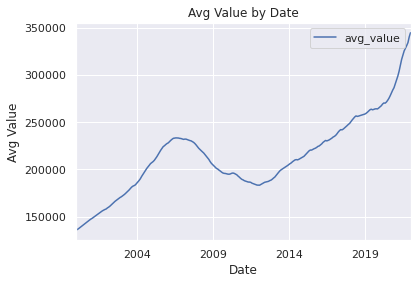

In [43]:
# Create a new data frame to average value per date. Keep observations starting from December 2008 to plot. 
national = final_df.groupby('variable')['value'].mean()
national = national.reset_index()
national.columns = ['variable', 'avg_value']
national = national[national['variable']>='2000-01-01']
print(national.head())

# Plot the data as a line plot. 
national.plot(x='variable', y='avg_value')
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date')
plt.show()

       variable State      avg_value
2304 2000-01-01    AK  161894.119097
2305 2000-01-01    AL  105849.711253
2306 2000-01-01    AR   62026.772502
2307 2000-01-01    AZ  128139.072010
2308 2000-01-01    CA  267527.287782


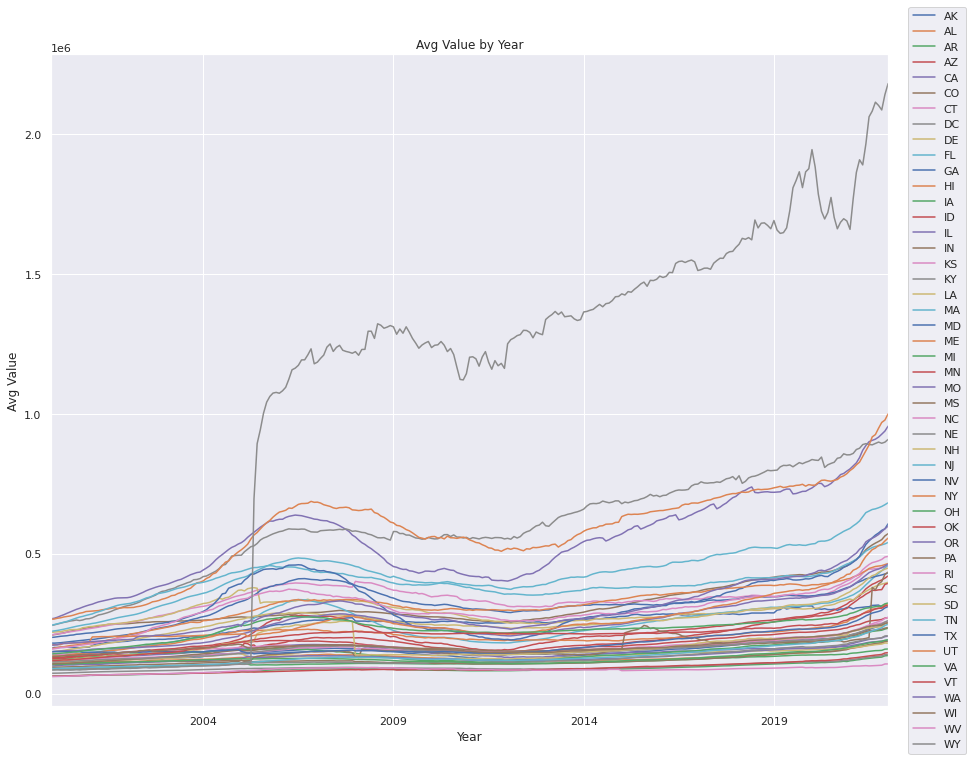

In [45]:
# Create a new data frame starting from December 2008 but looking at values at the state level
state = final_df.groupby(['variable', 'State'])['value'].mean()
state = state.reset_index()
state.columns = ['variable', 'State', 'avg_value']
state = state[state['variable']>='2000-01-01']
print(state.head())

# Pivot the data frame to produce multiple line plots
state_df = state.pivot(index='variable', columns='State', values='avg_value')

# Plot the data
state_df.plot(figsize=(15,12))
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Year')
plt.legend(loc='center right', bbox_to_anchor=[1.1, 0.5])
plt.show()

In [47]:
# Retain observations for December 2018. Then filter states with values above 700,000
dec_2018 = state[state['variable']=='2018-12-01']
top_three = dec_2018[dec_2018['avg_value']>=700000]

print(top_three[['State', 'avg_value']].sort_values('avg_value', ascending=False))

      State     avg_value
13247    WY  1.661603e+06
13207    DC  7.967430e+05
13211    HI  7.326685e+05
13204    CA  7.197984e+05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


       variable State      avg_value  pct_change
3408 2001-12-01    AK  186681.516192    0.124714
3984 2002-12-01    AK  193917.755740    0.038762
4560 2003-12-01    AK  205309.224132    0.058744
5136 2004-12-01    AK  224524.458660    0.093592
5712 2005-12-01    AK  246190.886411    0.096499


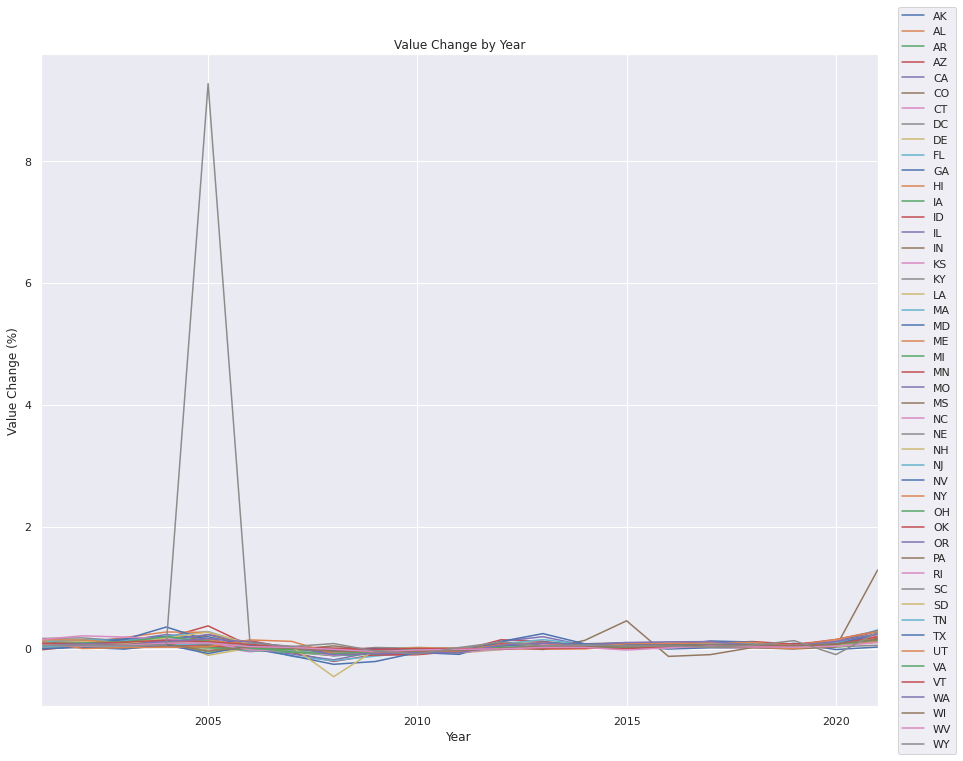

In [48]:
# Identify December observations
dec_obs = state['variable'].map(lambda x: x.month) == 12
state_dec = state[dec_obs]

# Calculate value percentage change for each state 
state_dec['pct_change'] = state_dec['avg_value'].div(state_dec.groupby('State')['avg_value'].shift(1))-1
state_dec = state_dec.dropna()
print(state_dec.sort_values(['State', 'variable']).head()) 

# Plot the percentage changes for each state. 
state_pct_df = state_dec.pivot(index='variable', columns='State', values='pct_change')

# Plot the data
state_pct_df.plot(figsize=(15,12))
_ = plt.xlabel('Year')
_ = plt.ylabel('Value Change (%)')
_ = plt.title('Value Change by Year')
plt.legend(loc='center right', bbox_to_anchor=[1.1, 0.5])
plt.show()

In [49]:
dec_2018_pct = state_dec[state_dec['variable']=='2018-12-01']
pct_10 = dec_2018_pct[dec_2018_pct['pct_change']>0.10]
print(pct_10[['State', 'pct_change']].sort_values('pct_change', ascending=False))

      State  pct_change
13213    ID    0.114438
13230    NV    0.106986
13241    UT    0.100496


In [50]:
# Filter the data, keeping only that for Arkansas and it's metro areo. 
arkansas = final_df[final_df['State'] == 'AR']
arkansas.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,variable,value
319,89249,332,71913,Zip,AR,AR,Hot Springs,Hot Springs,Garland County,1996-01-01,90749.60705
636,89319,664,72034,Zip,AR,AR,Conway,Little Rock-North Little Rock-Conway,Faulkner County,1996-01-01,102951.57060
824,89707,870,72701,Zip,AR,AR,Fayetteville,Fayetteville-Springdale-Rogers,Washington County,1996-01-01,94453.85799
866,89749,916,72764,Zip,AR,AR,Springdale,Fayetteville-Springdale-Rogers,Washington County,1996-01-01,97143.37658
1154,89528,1236,72401,Zip,AR,AR,Jonesboro,Jonesboro,Craighead County,1996-01-01,67316.32912


In [52]:
# Let's first look at how the data is distributed and how many NaN there are 
print(arkansas.describe())
print(len(arkansas))

               value
count  185296.000000
mean    83484.296100
std     48224.512464
min      9995.925436
25%     52171.334803
50%     70566.477840
75%    100302.857134
max    581532.000000
185296


In [53]:
# Keep NaN observations
nan_values = arkansas[np.isnan(arkansas['value'])==True]

# Count NaN by Metro
nan_values.groupby('Metro')['Metro'].count()

Series([], Name: Metro, dtype: int64)

In [55]:
# Variation over the last five months. 
print(arkansas.groupby('variable')['value'].describe().tail())

            count           mean  ...            75%          max
variable                          ...                            
2021-09-01  592.0  128587.895347  ...  152455.058325  556754.4394
2021-10-01  592.0  129453.549876  ...  152908.519500  554171.0988
2021-11-01  592.0  130634.217584  ...  154781.263525  564722.5166
2021-12-01  592.0  135054.345575  ...  160303.901925  575068.2331
2022-01-01  592.0  136190.986798  ...  161849.677650  581532.0000

[5 rows x 8 columns]


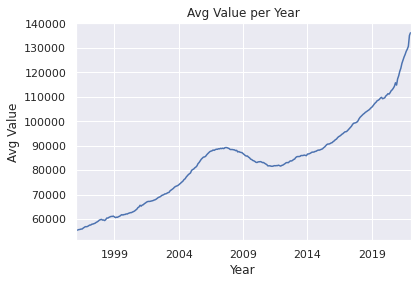

In [56]:
arkansas_avg = arkansas.groupby('variable')['value'].mean()
arkansas_avg.plot(x='variable', y='value')
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value per Year')
plt.show()

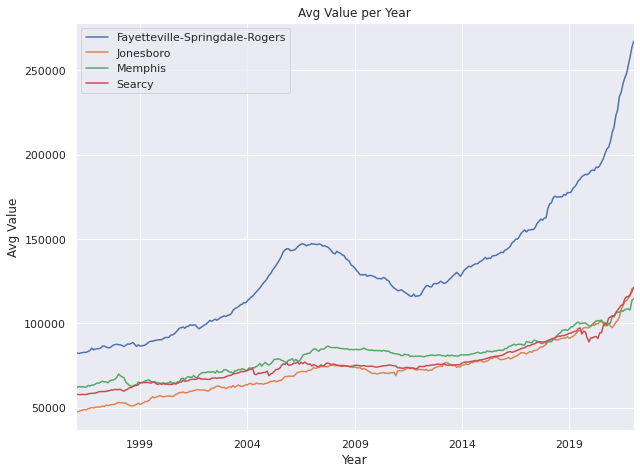

In [57]:
# Keep metro areas of Jonesboro, FSR, Searcy, and Memphis
arkansas_metro = arkansas[(arkansas['Metro']=='Jonesboro') |
                          (arkansas['Metro']=='Fayetteville-Springdale-Rogers') |
                          (arkansas['Metro']=='Searcy') |
                          (arkansas['Metro']=='Memphis')]

# Calculate average household value of the metro areas and plot
arkansas_metro_avg = arkansas_metro.groupby(['variable', 'Metro'])['value'].mean()
arkansas_metro_avg = arkansas_metro_avg.reset_index()

# Pivot the table
arkansas_metro_avg_pivot = arkansas_metro_avg.pivot(index='variable', columns='Metro', values='value')

# Plot
arkansas_metro_avg_pivot.plot(figsize=(10,7.5))
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value per Year')
plt.legend(loc='upper left')
plt.show()

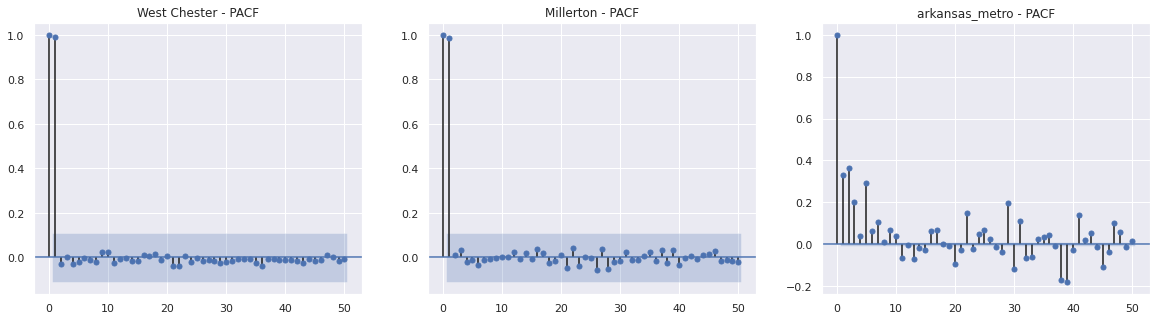

In [87]:
# Select a zip code to represent our data 
west_chester = final_df[final_df['RegionName']==19382]
millerton = final_df[final_df['RegionName']==16936]
west_palm_beach = final_df[final_df['RegionName']==33407]

# Set figure size
plt.figure(figsize=(20,5))

# Plot autocorrelation plot for 19382, 16936, and 33407 zip code to identify parameter starting point for ARIMA model
ax1 = plt.subplot(131)
plot_pacf(west_chester.value, lags=50, ax=ax1)
_ = plt.title('West Chester - PACF')

ax2 = plt.subplot(132)
plot_pacf(millerton.value, lags=50, ax=ax2)
_ = plt.title('Millerton - PACF')

ax3 = plt.subplot(133)
plot_pacf(arkansas_metro.value, lags=50, ax=ax3)
_ = plt.title('arkansas_metro - PACF')


plt.show()

In [91]:
# Transforming the West Chester subset 
arkansas_metro_simp = arkansas_metro[['variable', 'value']]
arkansas_metro_simp = arkansas_metro_simp.set_index('variable')

# Separate into training and test sets
WC_train = arkansas_metro.loc[:'2017-12-01']
WC_test = arkansas_metro.loc['2018-01-01':]

In [92]:
# Define the p, d and q parameters to take any value between 1 and 10
p = range(1, 5)
d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 0, 1) x (1, 0, 1, 12)
SARIMAX: (1, 0, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (2, 0, 0, 12)


In [ ]:
### WARNING: Do not run this segment as it takes too long to process. Only run if your computer has large processing power or if it's teh first time you're running this 
### model and need to adjust parameters. 

# Initiate list to store parameter conditions
aic_results = []

#Loop over parameter combinations and store them in list.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(WC_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            output = np.array([param, param_seasonal, results.aic])
            aic_results.append(output)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [63]:
# Convert aic_result list to dataframe and print lowest aic
aic_results_df = pd.DataFrame(np.array(aic_results).reshape(-1,3))
aic_results_df.columns = ['pdq', 'seasonal_pdq', 'aic']

# Print lowest AIC
aic_results_df.sort_values('aic').iloc[0]

pdq                 (4, 1, 1)
seasonal_pdq    (4, 1, 1, 12)
aic               3736.163388
Name: 255, dtype: object

In [64]:
# Run the model with the selected parameters
mod = sm.tsa.statespace.SARIMAX(WC_train,
                                order=(4, 1, 1),
                                seasonal_order=(4, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8574      0.142      6.044      0.000       0.579       1.135
ar.L2         -0.0276      0.118     -0.235      0.814      -0.259       0.203
ar.L3          0.0218      0.126      0.173      0.862      -0.225       0.268
ar.L4          0.1056      0.102      1.031      0.302      -0.095       0.306
ma.L1         -0.8181      0.103     -7.958      0.000      -1.020      -0.617
ar.S.L12      -0.1272      0.226     -0.562      0.574      -0.571       0.316
ar.S.L24      -0.0852      0.168     -0.506      0.613      -0.415       0.245
ar.S.L36       0.0409      0.138      0.298      0.766      -0.229       0.310
ar.S.L48       0.1195      0.070      1.713      0.087      -0.017       0.256
ma.S.L12      -0.5847      0.217     -2.691      0.007      -1.011      -0.159
sigma2      9.265e+06   6.35e-09   1.46e+15      0.0

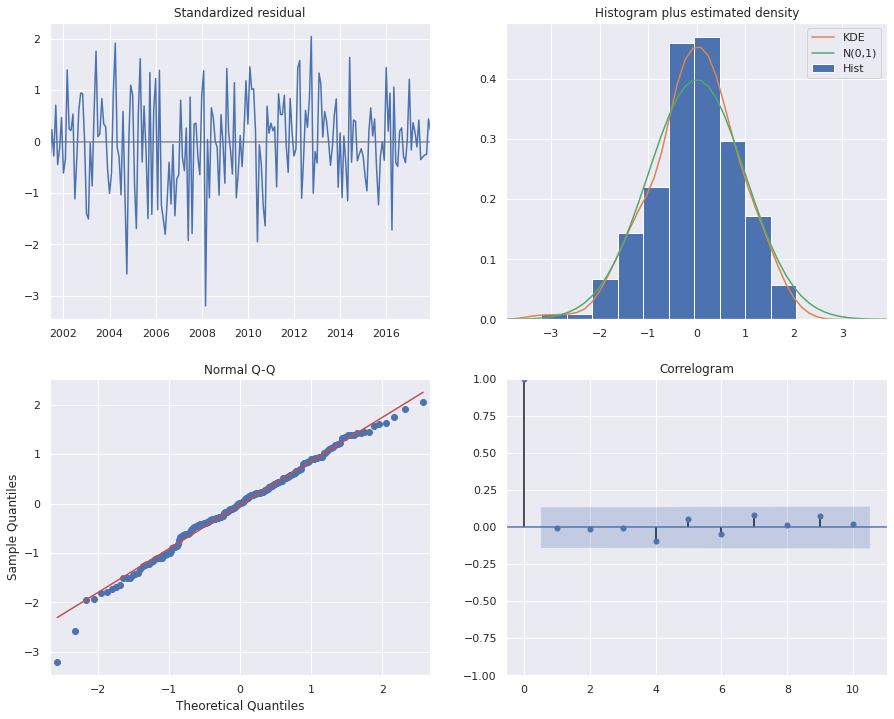

In [65]:
# Plot the model diagnostics. 
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [89]:
# Build a first validation using data from 2017 within the training set. 
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

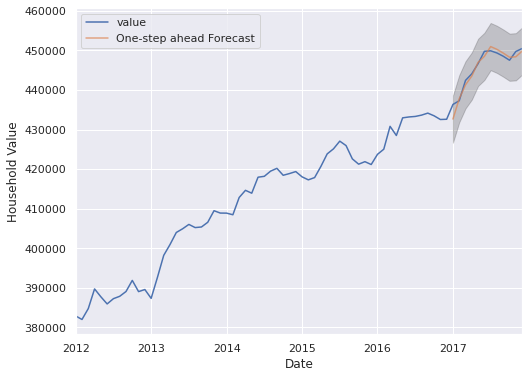

In [67]:
# Overlay the time-series plot with the predicted validation data. 
# We'll restrict showing the graphed data starting from 2012 to zoom into the time-series
ax = WC_train['2012-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8,6))

# Shade confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Household Value')
plt.legend()
plt.show()

In [70]:
# Obtain the predicted mean, merge with the actual values, and compute the MSE. 
y_forecasted = pred.predicted_mean.reset_index()
y_truth = WC_train['2017-01-01':].reset_index()

y_forecasted.columns = ['variable', 'value_pred']
y_merge = y_forecasted.merge(y_truth, how='inner', on='variable')

# Compute the mean square error
mae = mean_absolute_error(y_merge.value, y_merge.value_pred)
mse = mean_squared_error(y_merge.value, y_merge.value_pred)
r2 = r2_score(y_merge.value, y_merge.value_pred)

# Print the metric results. 
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The R-squared of our forecasts is {}'.format(round(r2, 2)))

The Mean Absolute Error of our forecasts is 1083.35
The Mean Squared Error of our forecasts is 1881534.62
The R-squared of our forecasts is 0.92


In [71]:
# Use the model to forecast twelve months into 2018 and store the confidence intervals
forecast = results.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2018-12-01'), dynamic=False)
forecast_ci = forecast.conf_int()

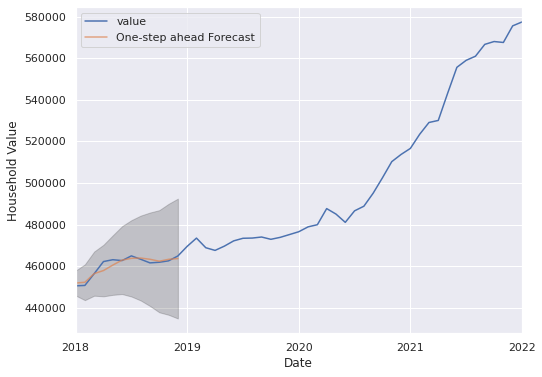

In [72]:
# Plot the actual results for 2018 vs the projected results. 
ax = WC_test['2018-01-01':].plot(label='observed')
forecast.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8,6))

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Household Value')
plt.legend(loc='upper left')
plt.show()

In [75]:
# Build prophet model with 95% confidence interval, looking at yearly seasonality with prior changepontis
# set to 6 months and seasonality change point set to 1 month. 
m1 = Prophet(interval_width=.95, changepoint_prior_scale=6, yearly_seasonality=True, 
             seasonality_prior_scale=1)
m1.add_seasonality(name='monthly', period=120, fourier_order=4)
WC_train2 = WC_train.reset_index()
WC_train2.columns = ['ds', 'y']
m1.fit(WC_train2)

# Look at the next 12 months. 
future_dates = m1.make_future_dataframe(periods=12, freq='MS')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [76]:
# Forecast next 12 months with confidence intervals
forecast = m1.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
271,2018-08-01,461924.629509,452110.916429,472618.714162
272,2018-09-01,463143.093462,452858.577690,476880.163845
273,2018-10-01,463642.100693,449885.550649,477891.371046
274,2018-11-01,465521.293680,450208.316677,484189.755819
275,2018-12-01,465501.804740,448056.412385,485869.934601


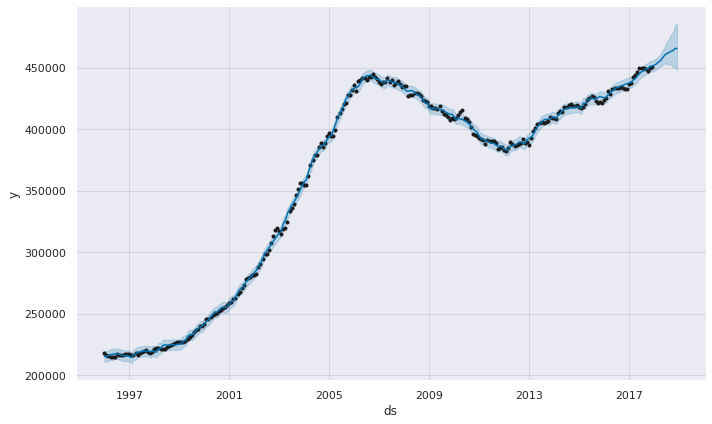

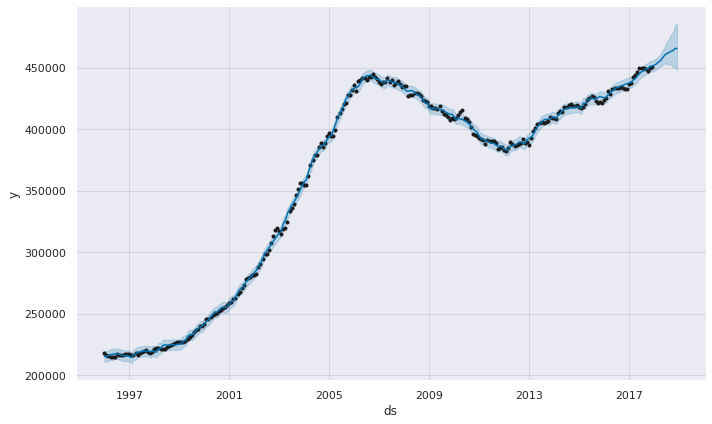

In [77]:
# Plot model with forecast trend values and uncertainty. 
m1.plot(forecast, uncertainty=True)

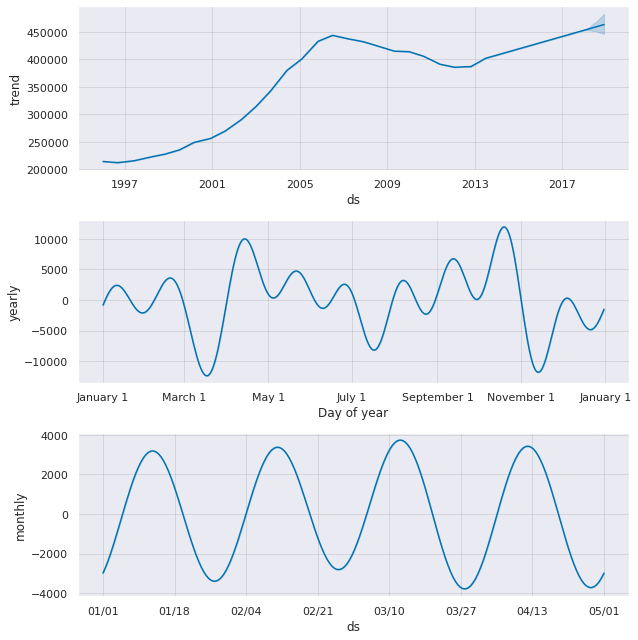

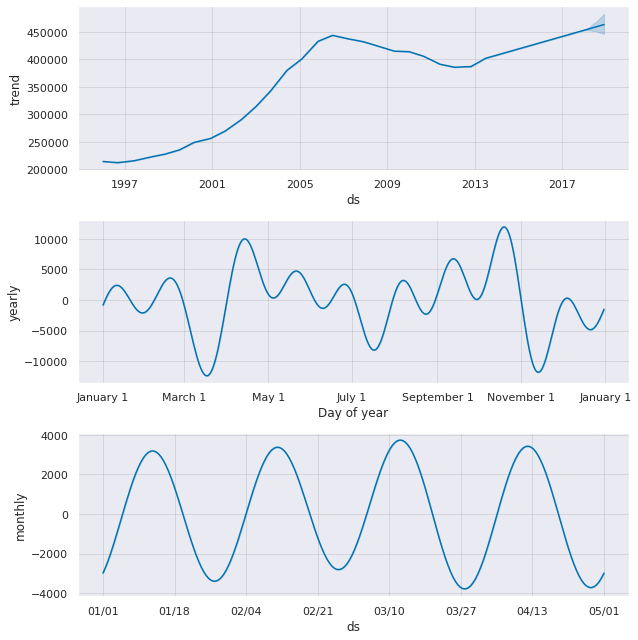

In [78]:
# Plot trend, yearly, and monthly seasonilities.
m1.plot_components(forecast)

In [79]:
# Calculate MAE, MSE, and R-squared. 
mae_prophet = mean_absolute_error(WC_test.value, forecast[forecast['ds']>='2018-01-01'].yhat)
mse_prophet = mean_squared_error(WC_test.value, forecast[forecast['ds']>='2018-01-01'].yhat)
r2_prophet = r2_score(WC_test.value, forecast[forecast['ds']>='2018-01-01'].yhat)

# Print metrics
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae_prophet, 2)))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_prophet, 2)))
print('The R-squared of our forecasts is {}'.format(round(r2_prophet, 2)))

ValueError: ignored